# INITIALIZE

In [1]:
## include packages

using DelimitedFiles
#using GaussDCA
using DCAUtils
using Plots
using FastaIO
using StatsBase
using Random
using MultivariateStats
using Statistics
using KitMSA
using PyPlot
using PyCall
using Distributions
#using NaNStatistics
using LaTeXStrings

@pyimport seaborn as sns
@pyimport numpy as np
@pyimport scipy.stats as stats
@pyimport matplotlib.colors as cols
@pyimport matplotlib.cm as mtcm
@pyimport matplotlib.ticker as tick


In [2]:
## load model parameters 

PATH_PAR = "../../scra_data_beta/Parameters_conv_Matteo_pc.dat"
h, J = KitMSA.extract_params(PATH_PAR;q=21)
;

In [3]:
## define functions

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end


function adjust_two_point(matrix, freqs)
    N = Int.(length(freqs)/20)
    q = 20
    for i in 1:N
        for j in 1:N
            for a in 1:20
                for b in 1:20
                    if i != j 
                        matrix[a+(i-1)*q , b+(j-1)*q]-=freqs[a+(i-1)*q]*freqs[b+(j-1)*q]
                    end
                end
            end
        end
    end
end


function build_seq_matrices(matrices)
    n_seqs_per_chain = length(matrices[1][:, 1])
    n_chains = length(matrices)
    return [vcat([matrices[i][j, :] for i in 1:n_chains]'...) for j in 1:n_seqs_per_chain]
end
                
function get_steps(file)
    vec_text = readlines(file)[5:4:end]
    vec_step = ["1" for i in 1:length(vec_text)]
    for (i, str) in enumerate(vec_text)
       vec_step[i] = split(str)[8]
    end
    return parse.(Int64, vec_step)
end
                            
function one_hot(msa::Array{Int8,2})
    M, N = size(msa)
    new_msa = zeros(M, N*21)
    for i in 1:M
        for j in 1:N
            index = msa[i,j]  
            new_msa[i, (j-1)*21 + index] = 1
        end
    end
    return new_msa
end

function one_hot(seq::Array{Int8,1})
    N = length(seq)
    new_msa = zeros(N*21)
    for j in 1:N
        index = seq[j]  
        new_msa[(j-1)*21 + index] = 1
    end
    return new_msa
end
                                                
function my_log2(x)
    if x == 0
        return 0                                                
    else
        return log2(x)
    end
end                                                
                                                    
                                                                                
                                                
function cie_fast(MSA)
    M, L = size(MSA)
    W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0; verbose=true)
    fi, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)
    #fi, fij = DCAUtils.add_pseudocount(fi, fij, 1/Meff)

    # Preallocate the space for p and entropy
    p = Vector{Float64}(undef, 20)
    entropy = Vector{Float64}(undef, L)

    for i in 1:L
        # Extract the relevant slice of fi just once
        fi_slice = @view fi[((i-1)*20 + 1): i*20]
        
        # Normalize p in-place
        sum_fi = sum(fi_slice)
        @. p = fi_slice / sum_fi
        
        # Compute entropy using a vectorized log2 operation
        entropy[i] = -sum(p .* my_log2.(p))
    end
    
    return entropy
end
                                                        
                                                        
function cie(MSA)
    M, L = size(MSA)
    W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0.2; verbose=true)
    fi, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)
    fi, fij = DCAUtils.add_pseudocount(fi, fij, 1/Meff)

    # Preallocate the space for p and entropy
    p = Vector{Float64}(undef, 20)
    entropy = Vector{Float64}(undef, L)

    for i in 1:L
        # Extract the relevant slice of fi just once
        fi_slice = @view fi[((i-1)*20 + 1): i*20]
        
        # Normalize p in-place
        sum_fi = sum(fi_slice)
        @. p = fi_slice / sum_fi
        
        # Compute entropy using a vectorized log2 operation
        entropy[i] = -sum(p .* my_log2.(p))
    end
    
    return entropy
end


function get_rank(vec)
    L = length(vec)
    rank = [NaN for i in 1:L]
    index_no_nan = [i for i in 1:L if !isnan(vec[i])]
    vec_no_nan = vec[index_no_nan]
    r = [percentilerank(vec_no_nan, x) for x in vec_no_nan]/100
    rank[index_no_nan] .= r
    return rank
end

function nancorspearman(v1, v2)
    not_nan = (!).(isnan.(v1) .& isnan.(v2))
    not_zero = (!).((v1 .== 0) .& (v2 .== 0))
    mask = not_nan .& not_zero                                                                        
    #v1_n = [val == 0.0 ? rand()/100 : val for val in v1[not_nan]]
    #v2_n = [val == 0.0 ? rand()/100 : val for val in v2[not_nan]]
    v1_n = v1[mask]                                                                            
    v2_n = v2[mask]
                                                                            
    return cor(invperm(sortperm(v1_n)), invperm(sortperm(v2_n)))
end                                                                    
                                                                            
                                                                            
                                                                            

nancorspearman (generic function with 1 method)

# DATA

In [4]:
## read alignments from evolutionary trajectories

folder_path = "../data/files_amino_mixed_pse_steps60000000_seqs1000_T1.0p0.5/"
output_folder = "../img/"
sampler_type = "mixed"

fasta_files = filter(file -> endswith(file, ".$(sampler_type)DNA"), readdir(folder_path))
matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
S = length(step_matrices[1][:,1])
N = length(step_matrices[1][1,:])
println(N," ", S)
steps = pushfirst!(get_steps(joinpath(folder_path, fasta_files[1])), 0)


mean_dist_steps = [mean(pairwise_hamming(matrix)) for matrix in step_matrices]
std_dist_steps = [std(pairwise_hamming(matrix)) for matrix in step_matrices]
;  

# natural seqs
path_nat = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
W_nat = DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
idxs = sample(1:length(W_nat), Weights(W_nat), S, replace=true)
trimmed_nat = nat_MSA[idxs,:]
r_nat = sample(1:size(nat_MSA, 1), S)

# hamming distance from PSE-1, weighted
M = size(nat_MSA, 1)
mean_hamming_nat = 100*mean([KitMSA.my_hamming(PSE1, nat_MSA[k, :]) for k in 1:M])/length(PSE1)
weighted_mean_hamming_nat = 100*sum(W_nat .* [KitMSA.my_hamming(PSE1, nat_MSA[k, :]) for k in 1:M])/(length(PSE1)*sum(W_nat))


# pairwise distance natural and sampled sequences
dp = pairwise_hamming(step_matrices[end])
dp_nat = pairwise_hamming(trimmed_nat)
;




LoadError: IOError: readdir("../data/files_amino_mixed_pse_steps60000000_seqs1000_T1.0p0.5/"): no such file or directory (ENOENT)

In [5]:
## get silico and experimental evolution data

# wt sequences
path_wt_pse = "../data/alignments/refs/PSE-1_masked.fa"
path_wt_tem = "../data/alignments/refs/TEM-1_fantini_pfam.fa"
PSE1 = join(readdlm(path_wt_pse, skipstart = 1))
TEM1 = join(readdlm(path_wt_pse, skipstart = 1))

# model and experimental alignments
MSA_tem_exp = Int8.(fasta2matrix("../data/alignments/experimental/fantini.max.6.gaps.gen12.fa"))
MSA_tem_dca = Int8.(fasta2matrix("../data/alignments/silico/new_version_det_bal_TEM_silico_seqs_34431_T_1.14_MCsteps_109.gibbsDNA"))
MSA_pse_exp = Int8.(fasta2matrix("../../scra_data_beta/cleaned_aligned_stiffler_MSA_big.fasta"))
MSA_pse_dca = Int8.(fasta2matrix("../../scra_data_beta/new_version_det_bal_PSE_silico_seqs_456871_T_1.4_MCsteps_120.gibbsDNA"))

# size of the alignments
M_pse_dca = size(MSA_pse_dca, 1)
M_pse_exp = size(MSA_pse_exp, 1)
M_tem_dca = size(MSA_tem_dca, 1)
M_tem_exp = size(MSA_tem_exp, 1)


folder_path = "../../scra_data_beta/cod_bias_amino_mixed_pse_steps120_seqs456871_T1.0p0.0"

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matr_dna = [fasta2matrix(joinpath(folder_path, file))
    for file in fasta_files]
@time step_matrices = build_seq_matrices(matr_dna);

MSA_pse_dca_cod_bias = step_matrices[end];

3884.771592 seconds (44.09 M allocations: 15.922 GiB, 0.81% gc time, 0.01% compilation time)
 72.841915 seconds (31.03 M allocations: 5.981 GiB, 58.97% gc time, 2.78% compilation time)


In [40]:
## get PCA

# one hot encoding of natural alignment
one_hot_nat = one_hot(nat_MSA)
W_nat=DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]

# compute covariance of data
cov_nat = cov(one_hot_nat, pweights(W_nat))

# compute eigenvalues and eigenvectors of covariance matrix
eigenvecs_nat = eigvecs(cov_nat)
eigenvals_nat = eigvals(cov_nat)

# project natural data onto principal components
pc_nat = eigenvecs_nat[:, [end, end-1]]'*one_hot_nat'
;

θ = 0.2 threshold = 40.0
M = 18334 N = 202 Meff = 6875.804074759526


In [5]:
## compute principal components for silico and experimental data

# pc of pse exp seqs
r_pse_exp = sample(1:M_pse_exp, 1000)
one_hot_pse_exp = one_hot(MSA_pse_exp[ r_pse_exp , :])
pc_pse_exp = eigenvecs_nat[:, [end, end-1]]'*one_hot_pse_exp'


# pc of pse dca seqs
r_pse_dca = sample(1:M_pse_dca, 1000)
one_hot_pse_dca = one_hot(MSA_pse_dca[ r_pse_dca , :])
pc_pse_dca = eigenvecs_nat[:, [end, end-1]]'*one_hot_pse_dca'


# pc of tem exp seqs
r_tem_exp = sample(1:M_tem_exp, 1000)
one_hot_tem_exp = one_hot(MSA_tem_exp[ r_tem_exp , :])
pc_tem_exp = eigenvecs_nat[:, [end, end-1]]'*one_hot_tem_exp'


# pc of tem dca seqs
r_tem_dca = sample(1:M_tem_dca, 1000)
one_hot_tem_dca = one_hot(MSA_tem_dca[ r_tem_dca , :])
pc_tem_dca = eigenvecs_nat[:, [end, end-1]]'*one_hot_tem_dca'


# pc of tem and pse
one_hot_pse = one_hot(Int8.(PSE1))
pc_PSE = eigenvecs_nat[:, [end, end-1]]'*one_hot_pse

one_hot_tem = one_hot(Int8.(TEM1))
pc_TEM = eigenvecs_nat[:, [end, end-1]]'*one_hot_tem
;

LoadError: UndefVarError: `eigenvecs_nat` not defined

In [6]:
## get CIE for all datasets

# compute CIE short term
cie_tem_exp = cie_fast(MSA_tem_exp)
cie_tem_exp[end] = NaN
cie_tem_exp[end-1] = NaN
cie_tem_dca = cie_fast(MSA_tem_dca)
cie_pse_exp = cie_fast(MSA_pse_exp)
cie_pse_dca = cie_fast(MSA_pse_dca)
cie_pse_dca_cod_bias = cie_fast(MSA_pse_dca_cod_bias);
tem_cor = nancorspearman(cie_tem_dca, cie_tem_exp)
pse_cor = nancorspearman(cie_pse_dca, cie_pse_exp)
pse_cor_cod_bias = nancorspearman(cie_pse_exp, cie_pse_dca_cod_bias)

# compute cie natural seqs
#cie_nat = cie(nat_MSA)

# rank
cie_tem_dca2 = get_rank(cie_tem_dca)
cie_tem_exp2 = get_rank(cie_tem_exp)
cie_pse_dca2 = get_rank(cie_pse_dca)
cie_pse_exp2 = get_rank(cie_pse_exp)
tem_cor2 = nancorspearman(cie_tem_dca2, cie_tem_exp2)
#pse_cor2 = nancorspearman(cie_pse_dca2, cie_pse_exp2)
cie_nat2 = get_rank(cie_nat)
;

θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431
θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431
θ = 0.0 threshold = 0.0
M = 456410 N = 202 Meff = 456410
θ = 0.0 threshold = 0.0
M = 456871 N = 202 Meff = 456871
θ = 0.0 threshold = 0.0
M = 456871 N = 202 Meff = 456871


LoadError: UndefVarError: `cie_nat` not defined

In [9]:
## get statistics of alignments

MSA = MSA_tem_dca
M, L = size(MSA)
W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0; verbose=true)
fi_dca, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)

MSA = MSA_tem_exp
M, L = size(MSA)
W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0; verbose=true)
fi_exp, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)
;

θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431
θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431


# FIGURES

In [7]:
## global parameters

fs_label = 15
fs_ax = 13
fs_leg = 11
bw = 0.8
bw_exp = 0.65
;

## FIG. 1B / 1S C

In [8]:
## rank_flag = true produces figure 1S C
## rank_flag = false produces figure 1B

rank_flag = false

false

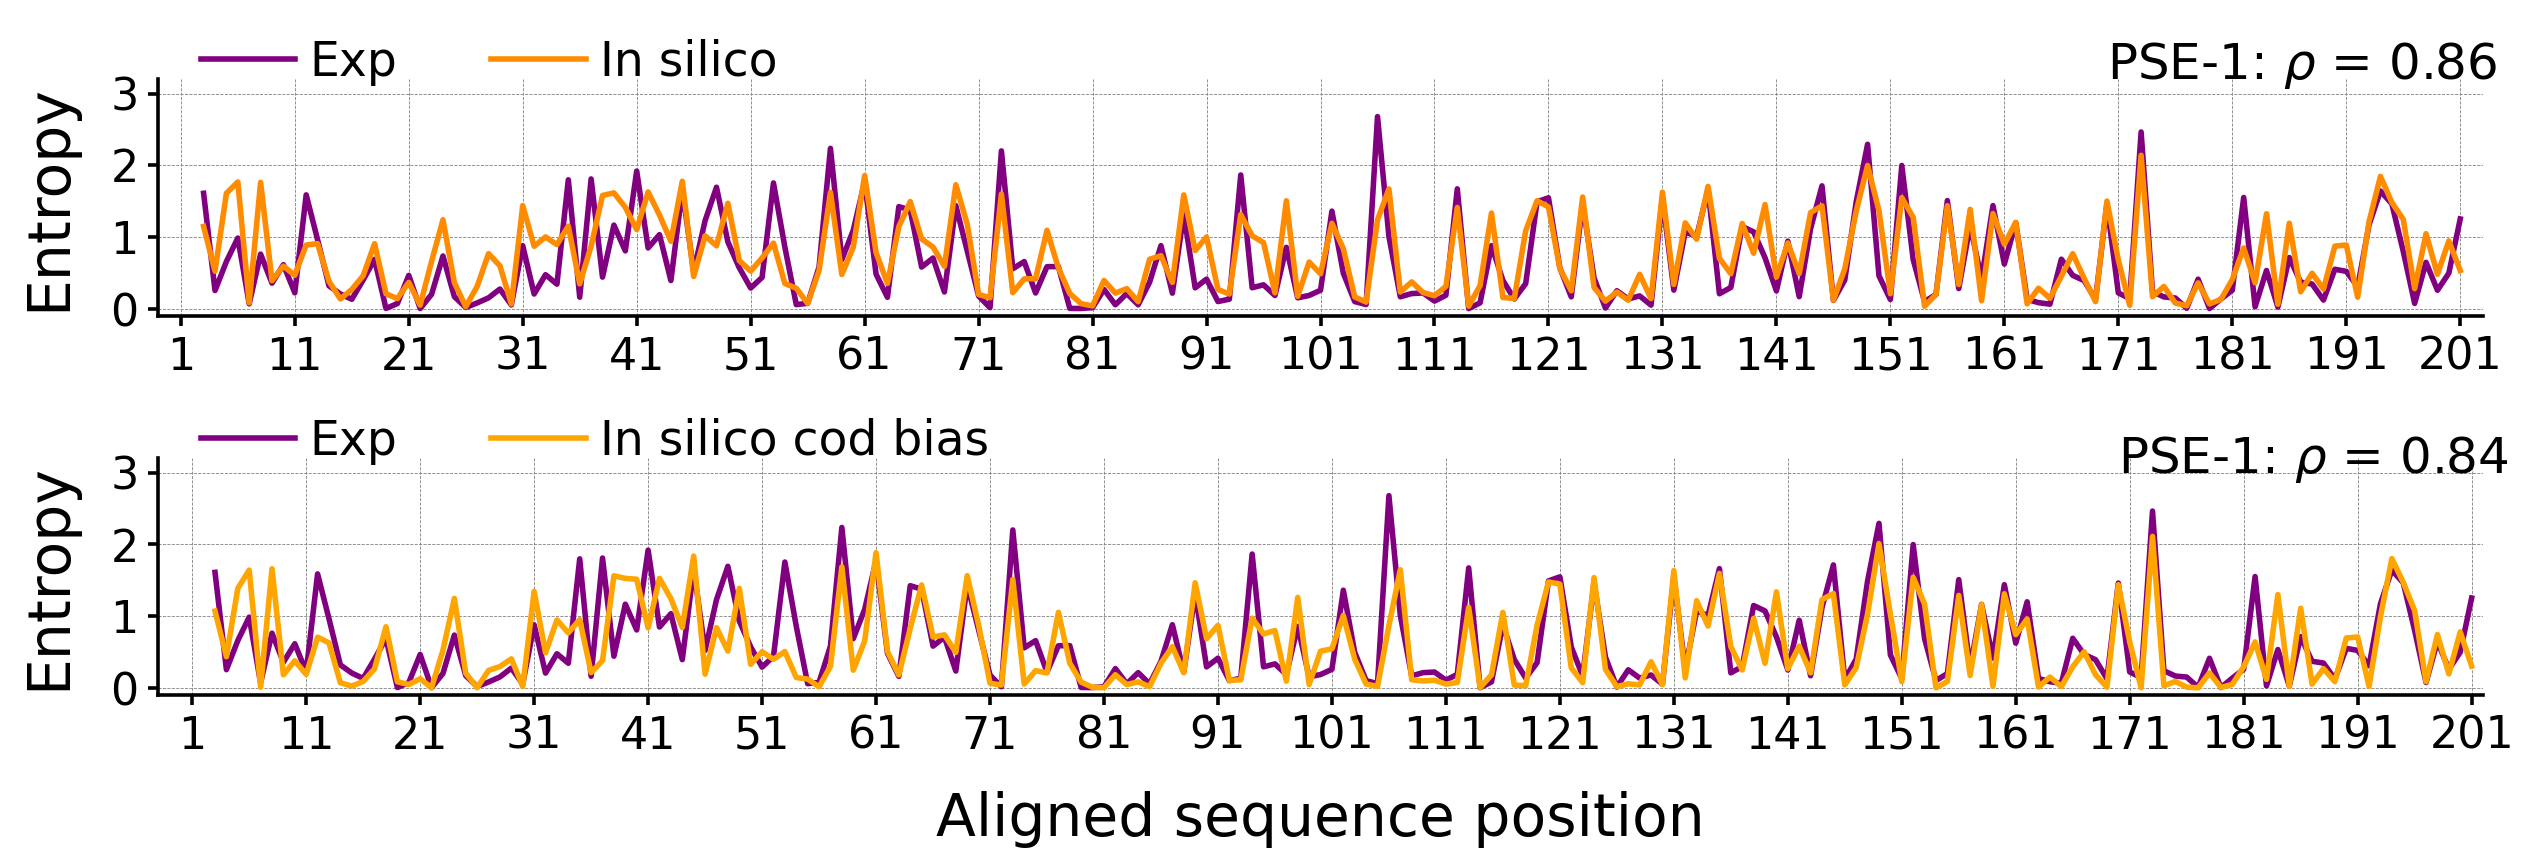

PyObject <matplotlib.legend.Legend object at 0x7fda5393dc70>

In [9]:
## plot figure

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 4), dpi = 200)

ax1.grid(color="grey",  linewidth=0.3, linestyle="--")
ax2.grid(color="grey",  linewidth=0.3, linestyle="--")

subplots_adjust(hspace = 0.6)

XX = collect(1:202)

ax1.spines["right"].set_visible(false)
ax1.spines["top"].set_visible(false)

for side in ["top","bottom","left","right"]
    ax1.spines[side].set_linewidth(1.3)
    ax2.spines[side].set_linewidth(1.3)
end

ax1.tick_params(width=1.3)
ax2.tick_params(width=1.3)

if rank_flag
    ax1.fill_between(XX, -ones(length(XX)), cie_nat2, color = "grey", alpha = 0.2)
    ax1.plot(XX, cie_tem_exp2, color = "purple", linewidth = 2, alpha = 1)
    ax1.plot(XX, cie_tem_dca2, color = "darkorange", linewidth = 2, alpha = 1)
    ax1.set_ylabel("Rank\n entropy", fontsize = 21, labelpad = 12)
    ax1.text(170, 1.3,"TEM-1: "* L"\rho"*" = $(round(tem_cor2, digits = 2))", fontsize = 18)
    ax1.set_ylim(-0.1, 1.3)
else
    ax1.plot(XX, cie_pse_exp, color = "purple", linewidth = 2, alpha = 1, label = "Exp")
    ax1.plot(XX, cie_pse_dca, color = "darkorange", linewidth = 2, alpha = 1, label = "In silico")
    #=ax1.plot(XX, cie_tem_exp, color = "purple", linewidth = 2, alpha = 1)
    ax1.plot(XX, cie_tem_dca, color = "darkorange", linewidth = 2, alpha = 1)=#
    ax1.text(170, 3.2,"PSE-1: "* L"\rho"*" = $(round(pse_cor, digits = 2))", fontsize = 18)
    
    ax1.set_ylabel("Entropy", fontsize = 21, labelpad = 12)
    ax1.set_ylim(-0.1, 3.2)
    ax1.set_yticks([0, 1, 2, 3])
end

ax1.set_xlim(-1, 203)
ax1.tick_params(axis="both", which="major", labelsize= 16)
ax1.set_xticks(collect(1:10:202))
ax1.set_xticklabels(collect(1:10:202))


#ax1.legend(bbox_to_anchor=(0, 1.5), loc="upper left", fontsize = 12)

ax2.spines["right"].set_visible(false)
ax2.spines["top"].set_visible(false)
if rank_flag
    ax2.fill_between(XX, -ones(length(XX)), cie_nat2, color = "grey", alpha = 0.2, label = "Natural sequences")
    ax2.plot(XX, cie_pse_exp2, color = "purple", linewidth = 2, alpha = 1, label = "Exp")
    ax2.plot(XX, cie_pse_dca2, color = "darkorange", linewidth = 2, alpha = 1, label = "In silico")
    ax2.set_ylabel("Rank\n entropy", fontsize = 21, labelpad = 12)
    ax2.text(170, 1.1,"PSE-1: "* L"\rho"*" = $(round(pse_cor2, digits = 2))", fontsize = 18)
    ax2.set_ylim(-0.1, 1.2)
else
    ax2.plot(XX, cie_pse_exp, color = "purple", linewidth = 2, alpha = 1, label = "Exp")
    #ax2.plot(XX, cie_pse_dca, color = "darkorange", linewidth = 2, alpha = 1, label = "In silico")
    ax2.plot(XX, cie_pse_dca_cod_bias, color = "orange", linewidth = 2, alpha = 1, label = "In silico cod bias")
    ax2.set_ylabel("Entropy", fontsize = 21, labelpad = 12)
    
    #ax2.text(170, 3.2,"PSE-1: "* L"\rho"*" = $(round(pse_cor, digits = 2))", fontsize = 18)
    ax2.text(170, 3,"PSE-1: "* L"\rho"*" = $(round(pse_cor_cod_bias, digits = 2))", fontsize = 18)
    ax2.set_ylim(-0.1, 3.2)
    ax2.set_yticks([0, 1, 2, 3])
end
ax2.set_xlim(-2, 202)

ax2.tick_params(axis="both", which="major", labelsize= 16)
ax2.set_xlabel("Aligned sequence position", fontsize = 21, labelpad = 12)
ax2.set_xticks(collect(1:10:202))
ax2.set_xticklabels(collect(1:10:202))



if rank_flag
    ax2.legend(bbox_to_anchor=(0, 3), loc="upper left", fontsize = 17, ncol = 3, 
    frameon = false, handletextpad = 0.3)
    #plt.savefig("../img/paper_PNAS/1S_C", bbox_inches = "tight", dpi = 300)
else
    ax1.legend(bbox_to_anchor=(0, 1.35), loc="upper left", fontsize = 17, ncol = 3, 
    frameon = false, handletextpad = 0.3)
    ax2.legend(bbox_to_anchor=(0, 1.35), loc="upper left", fontsize = 17, ncol = 3, 
    frameon = false, handletextpad = 0.3)
    #plt.savefig("../data/figures/cod_bias_entropy.png", bbox_inches = "tight", dpi = 300)
end

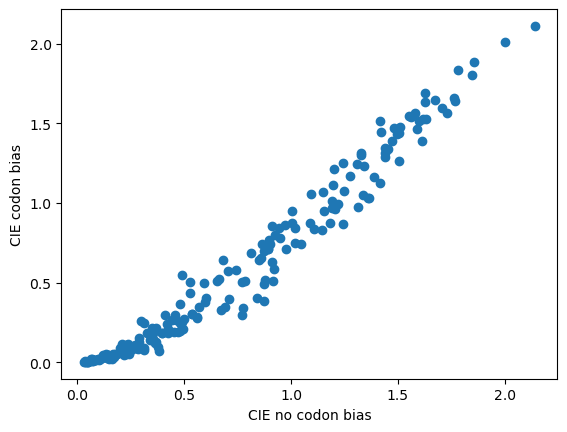

In [15]:

corrr = nancorspearman(cie_pse_dca[:], cie_pse_dca_cod_bias[:])
plt.scatter(cie_pse_dca, cie_pse_dca_cod_bias, label = round(corrr, digits = 3))
plt.xlabel("CIE no codon bias")
plt.ylabel("CIE codon bias")
PyPlot.savefig("../corr_bias_no_bias_pse_exptime.png")

## FIG. 1C-D / 1S A

In [13]:
## precompute quantities

# define what points of the trajectory to show
total_steps = length(step_matrices)
traj_index = [4, 7, 18, 30, 55, 65, total_steps]
num_curves = length(traj_index)

# compute pc along trajectory
pc_vec = [Array{Float64}(undef, 0, 2) for i in 1:num_curves]
for (i, index) in enumerate(traj_index[end:-1:1])
    one_hot_proj = one_hot(step_matrices[index])
    pc_vec[i] = eigenvecs_nat[:, [end, end-1]]'*one_hot_proj'
end

# mean hamming distance
mean_hamming = [sum([KitMSA.my_hamming(PSE1, step_matrices[k][i, :]) for i in 1:1000])/1000 for k in 1:112]
mean_hamming_select = [sum([KitMSA.my_hamming(PSE1, step_matrices[k][i, :]) for i in 1:1000])/1000 for k in traj_index]
dist_perc = Int64.(round.(mean_hamming_select*100/length(PSE1), digits = 0))

# distance of experimental data
dist_tem = 109*2
dist_pse = 120*2
;

In [14]:
## contour = true produces figure 1S A
## contour = false produces figure 1C-D

contour = true


true

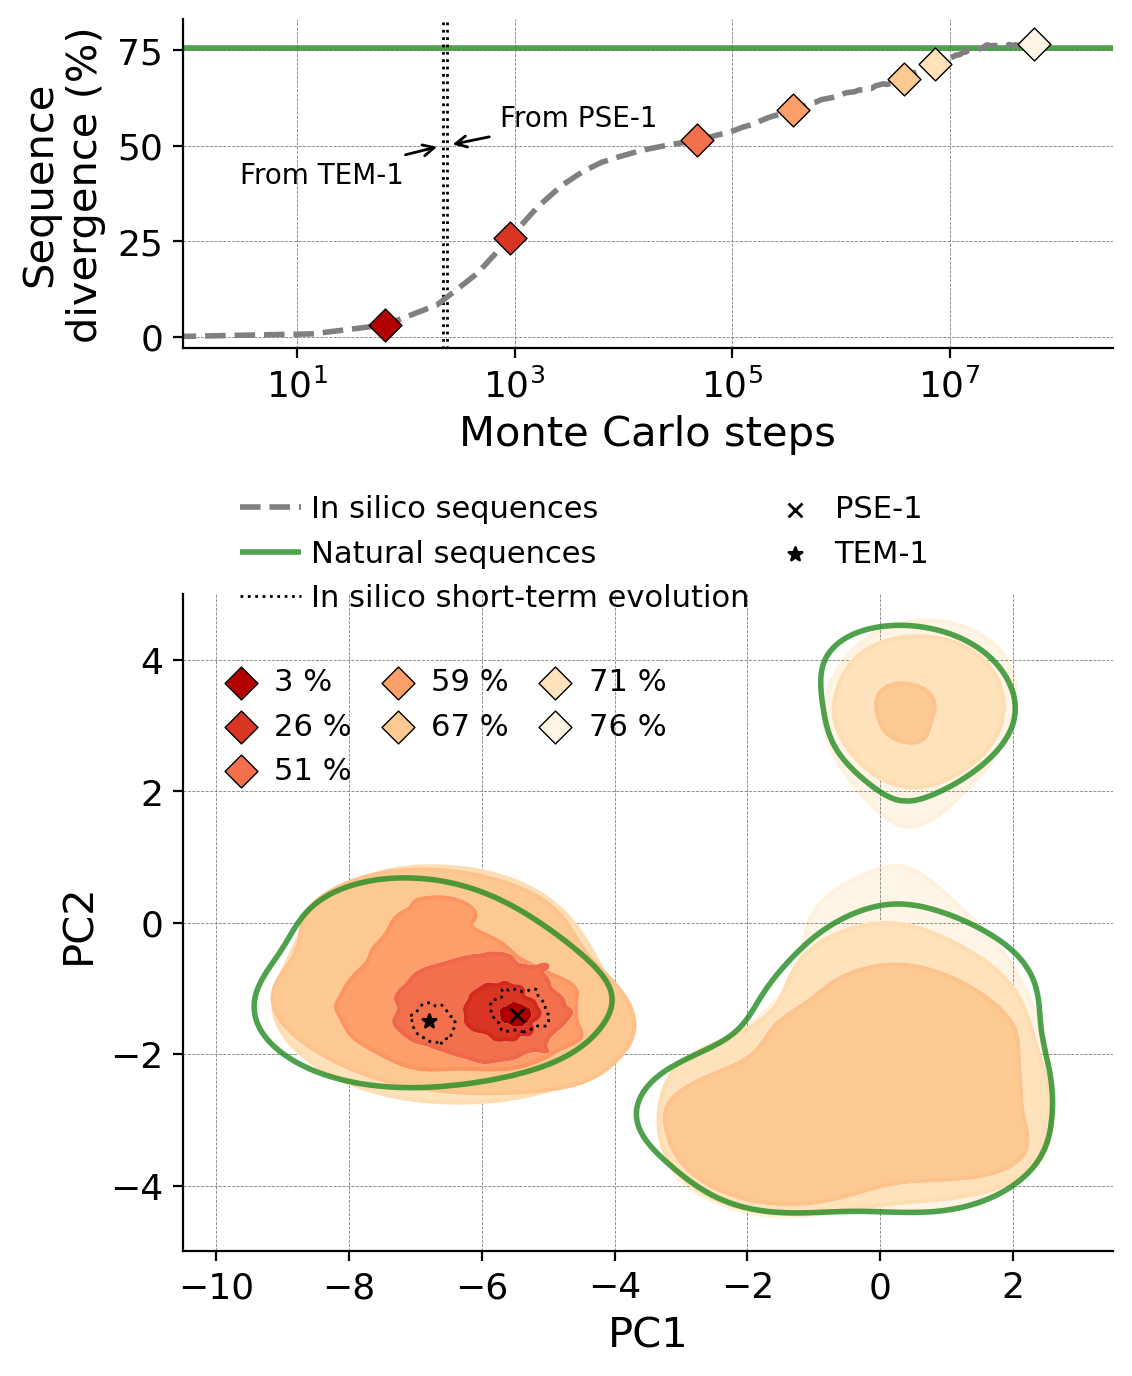

In [15]:
## plot figure

# define figure
kw = Dict("height_ratios" => [1,2])
fig, (axc, axd) = plt.subplots(2, 1, figsize = (6, 8), dpi = 200, 
gridspec_kw= kw)
subplots_adjust(hspace = 0.5)

########
## 1C ##
########

axc.spines["right"].set_visible(false)
axc.spines["top"].set_visible(false)
axc.grid(color="grey", linestyle="--", linewidth=0.3, zorder = 4)


axc.set_xscale("log")
axc.set_xlabel("Monte Carlo steps", fontsize = fs_label)
axc.set_ylabel("Sequence\ndivergence (%)", fontsize = fs_label)

axc.set_ylim(-3, 83)
axc.set_xlim(right = 10^(8.5))
axc.tick_params(axis="both", which="major", labelsize= fs_ax)



# Get the colormap
mycm = mtcm.get_cmap("OrRd")
my_color = mycm(collect(1:256))

c_vec = [ my_color[Int64(round( (i-1)/num_curves * 256 + 5)),:] for i in 1:num_curves][end:-1:1]

for (i, st) in enumerate(steps[traj_index])
    d = dist_perc[i]
    #ax.vlines(st, -5, 85, color = c_vec[i], alpha = 0.5, linewidth = 3) 
    axc.scatter(st, 100*mean_hamming_select[i]/length(PSE1), s = 70, 
    color = c_vec[i], marker = "D", zorder = 3, edgecolor = "black", linewidth = 0.5, 
    label = "$(d) %")
end

axc.hlines(weighted_mean_hamming_nat, 0, 10^9, color = "forestgreen", alpha = 0.8, linewidth = 2, 
linestyle = "-")

axc.plot(steps, 100*mean_hamming/length(PSE1), linewidth = 2, linestyle = "--",
color = "grey", label = "In silico sequences")


#axc.xaxis.set_minor_locator(tick.LogLocator(base=10, subs="auto"))
#axc.xaxis.minorticks_on()

handles_c, labels_c = axc.get_legend_handles_labels()


#axc.legend(pD, bbox_to_anchor=(0, -0.7), loc="upper left", 
#fontsize = fs_leg, ncol = 2, frameon = false, columnspacing = 0.5)


########
## 1D ##
########
axd.spines["right"].set_visible(false)
axd.spines["top"].set_visible(false)
axd.set_xlabel("PC1", fontsize = fs_label)
axd.set_ylabel("PC2", fontsize = fs_label) 
axd.set_ylim(-5, 5)
axd.set_xlim(-10.5, 3.5)

    
# define white color
w = ["white", "white"]
map_white = cols.LinearSegmentedColormap.from_list("custom_cmap", w, N=1)
b = ["black", "black"]
map_black = cols.LinearSegmentedColormap.from_list("custom_cmap", b, N=1)



# plot the densities
for i in 1:num_curves

    # get principal components
    pc = pc_vec[i]
    c_number = Int64(round( (i-1)/num_curves * 256 + 5))
    
    # new colormap
    cmap =  cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number, :], 
        my_color[c_number, :]], N=num_curves)
    cmap_cont = cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number + 7, :], 
        my_color[c_number, :]], N=num_curves)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, cmap = map_white, ax= axd, zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, cmap = map_white, ax = axd, zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, alpha = 1, cmap = cmap, ax = axd, 
    zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, alpha = 1,
    cmap = cmap_cont, ax = axd, zorder = i, 
    bw_adjust = bw)
end


# contour natural sequences
color_nat = cols.LinearSegmentedColormap.from_list("custom_cmap", ["forestgreen", "forestgreen"], N=1)
sns.kdeplot(x=pc_nat[1, r_nat], y=pc_nat[2, r_nat], levels=[0.1, 1], 
fill = false, alpha = 0.8, cmap = color_nat, linestyles="-", 
label = "Natural sequences", linewidths = 2, ax= axd, zorder = num_curves + 1, 
bw_adjust = bw)



###########
#PSE TEM LINES
###########

if contour
    axc.vlines(dist_pse, -5, 100, linestyles = "dotted", linewidths = 1, color = "black")
    axc.vlines(dist_tem, -5, 100, linestyles = "dotted", linewidths = 1, color = "black")

    axc.annotate("From PSE-1", (dist_pse, 50), (dist_pse + 500, 55), 
    arrowprops = Dict("arrowstyle" => "->"), fontsize = 10)

    axc.annotate("From TEM-1", (dist_tem, 50), (3, 40), 
    arrowprops = Dict("arrowstyle" => "->"), fontsize = 10)

    # contour pse simulated
    color_pse = cols.LinearSegmentedColormap.from_list("custom_cmap", ["black", "black"], N=1)
    sns.kdeplot(x=pc_pse_dca[1, :], y=pc_pse_dca[2, :], levels=[0.1, 1], 
    fill = false, alpha = 1, cmap = color_pse, linestyles="dotted", linewidths = 1, ax = axd, zorder = num_curves + 1, 
    bw_adjust = bw)

    # contour tem simulated
    color_tem = cols.LinearSegmentedColormap.from_list("custom_cmap", ["black", "black"], N=1)
    sns.kdeplot(x=pc_tem_dca[1, :], y=pc_tem_dca[2, :], levels=[0.1, 1], 
    fill = false, alpha = 1, cmap = color_tem, linestyles="dotted", 
    label = "In silico short-term evolution", linewidths = 1, ax = axd, zorder = num_curves + 1, 
    bw_adjust = bw)
end

###########


# TEM-1 and PSE-1 points
pp = axd.scatter(pc_PSE[1], pc_PSE[2], s = 25, marker = "x", 
color = "black", label = "PSE-1", linewidth = 1, zorder = num_curves + 1)
pp = axd.scatter(pc_TEM[1], pc_TEM[2], s = 25, marker = "*", 
color = "black", label = "TEM-1", edgecolor = "black", zorder = num_curves + 1)

axd.tick_params(axis="both", which="major", labelsize=fs_ax)


axd.grid(color="grey", linestyle="--", linewidth=0.3, zorder = 4)



handles_d, labels_d = axd.get_legend_handles_labels()
handles_main = vcat(handles_c[1], handles_d)
labels_main = vcat(labels_c[1], labels_d)

handles_minor = handles_c[2:end]
labels_minor = labels_c[2:end]

axd.legend(handles_minor, labels_minor, bbox_to_anchor=(0, 0.93), loc="upper left", 
fontsize = fs_leg, ncol = 3, frameon = false, columnspacing = 0.5, handletextpad = 0.1)

fig.legend(handles_main, labels_main, bbox_to_anchor=(0.15, 0.6), loc="upper left", 
fontsize = fs_leg, ncol = 2, frameon = false, columnspacing = 0.5, handletextpad = 0.3)

if contour
    plt.savefig("../img/paper_PNAS/1S_A.png", bbox_inches = "tight", dpi = 300)
else
    plt.savefig("../img/paper_PNAS/1C-D.png", bbox_inches = "tight", dpi = 300)
end

## FIG. 1S B

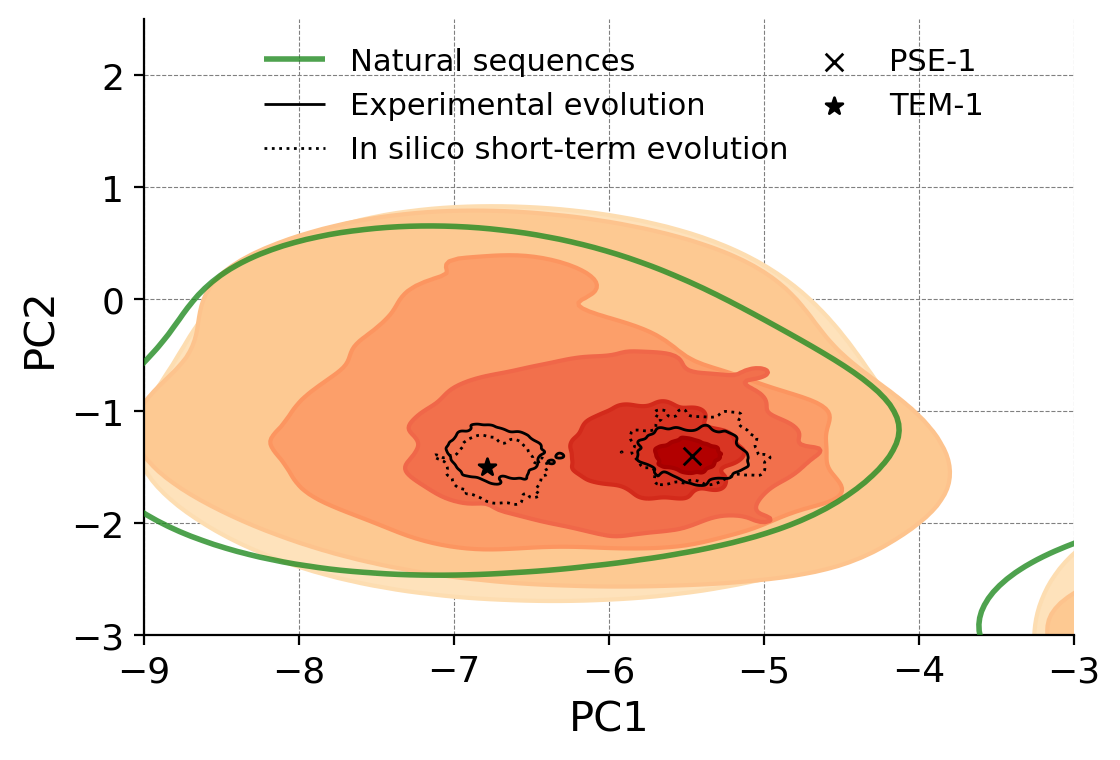

In [16]:
# define figure
fig, axd = plt.subplots(1, 1, figsize = (6, 4), dpi = 200)


########
## 1B ##
########
axd.spines["right"].set_visible(false)
axd.spines["top"].set_visible(false)
axd.set_xlabel("PC1", fontsize = fs_label)
axd.set_ylabel("PC2", fontsize = fs_label) 
axd.set_ylim(-3, 2.5)
axd.set_xlim(-9, -3)
axd.grid(color="grey", linestyle="--", linewidth=0.4)

    
# define white color
w = ["white", "white"]
map_white = cols.LinearSegmentedColormap.from_list("custom_cmap", w, N=1)
b = ["black", "black"]
map_black = cols.LinearSegmentedColormap.from_list("custom_cmap", b, N=1)



# Get the colormap
mycm = mtcm.get_cmap("OrRd")
my_color = mycm(collect(1:256))

# plot the densities
for i in 1:num_curves

    # get principal components
    pc = pc_vec[i]
    c_number = Int64(round( (i-1)/num_curves * 256 + 5))
    
    # new colormap
    cmap =  cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number, :], 
        my_color[c_number, :]], N=num_curves)
    cmap_cont = cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number + 7, :], 
        my_color[c_number, :]], N=num_curves)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, cmap = map_white, ax= axd, zorder = 1, 
     bw_adjust = bw_exp +0.1)
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, cmap = map_white, ax = axd, zorder = 1, 
     bw_adjust = bw_exp +0.1)
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, alpha = 1, cmap = cmap, ax = axd, zorder = 2, 
     bw_adjust = bw_exp +0.1)
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, alpha = 1, 
    cmap = cmap_cont, ax = axd, zorder = 2, bw_adjust = bw_exp +0.1)
end

# contour natural sequences
color_nat = cols.LinearSegmentedColormap.from_list("custom_cmap", ["forestgreen", "forestgreen"], N=1)
sns.kdeplot(x=pc_nat[1, r_nat], y=pc_nat[2, r_nat], levels=[0.1, 1], 
fill = false, alpha = 0.8, cmap = color_nat, linestyles="-", 
label = "Natural sequences", linewidths = 2, ax= axd, zorder = num_curves + 1,  bw_adjust = bw_exp +0.1)

# contour pse simulated
color_pse = cols.LinearSegmentedColormap.from_list("custom_cmap", ["black", "black"], N=1)
sns.kdeplot(x=pc_pse_dca[1, :], y=pc_pse_dca[2, :], levels=[0.1, 1], 
fill = false, alpha = 1, cmap = color_pse, linestyles="dotted", linewidths = 1, ax = axd, 
zorder = num_curves + 1, bw_adjust = bw_exp)

# contour pse exp
sns.kdeplot(x=pc_pse_exp[1, :], y=pc_pse_exp[2, :], levels=[0.1, 1], 
fill = false, alpha = 1, cmap = color_pse, linestyles="-", linewidths = 1, ax = axd, 
zorder = num_curves + 1,  bw_adjust = bw_exp)

# contour tem exp
sns.kdeplot(x=pc_tem_exp[1, :], y=pc_tem_exp[2, :], levels=[0.1, 1], 
fill = false, alpha = 1, cmap = color_tem, linestyles="-", 
label = "Experimental evolution", linewidths = 1, ax = axd, zorder = num_curves + 1,  bw_adjust = bw_exp)


# contour tem simulated
color_tem = cols.LinearSegmentedColormap.from_list("custom_cmap", ["black", "black"], N=1)
sns.kdeplot(x=pc_tem_dca[1, :], y=pc_tem_dca[2, :], levels=[0.1, 1], 
fill = false, alpha = 1, cmap = color_tem, linestyles="dotted", 
label = "In silico short-term evolution", linewidths = 1, ax = axd, zorder = num_curves + 1,  bw_adjust = bw_exp)


# TEM-1 and PSE-1 points
pp = axd.scatter(pc_PSE[1], pc_PSE[2], s = 40, marker = "x", 
color = "black", label = "PSE-1", linewidth = 1, zorder = num_curves + 1)
pp = axd.scatter(pc_TEM[1], pc_TEM[2], s = 40, marker = "*", 
color = "black", label = "TEM-1", edgecolor = "black", zorder = num_curves + 1)

axd.tick_params(axis="both", which="major", labelsize=fs_ax)
axd.legend(bbox_to_anchor=(0.1, 1), loc="upper left", 
fontsize = fs_leg, ncol = 2, frameon = false, columnspacing = 0.5)

plt.savefig("../img/paper_PNAS/1S_B", bbox_inches = "tight", dpi = 300)

#  OTHER FIGURES

## Histogram pairwise distances

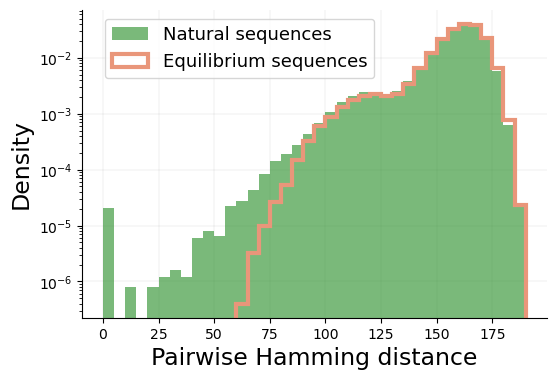

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
matplotlib.pyplot.grid(color="grey", linestyle="-", linewidth=0.3, alpha = 0.3)

plt.hist(dp_nat, bins = collect(0:5:190), alpha = 0.6, 
label = "Natural sequences", density=true, color = "forestgreen",histtype = "step",
linewidth = 0, fill = true)

plt.hist(dp, bins = collect(0:5:190), alpha = 1, density= true, 
label = "Equilibrium sequences", color = "darksalmon", histtype = "step", 
linewidth = 3, fill = false)
plt.yscale("log")
plt.xlabel("Pairwise Hamming distance", fontsize = 17)
plt.ylabel("Density", fontsize = 17)
plt.legend(bbox_to_anchor=(0.03, 1), loc="upper left", fontsize = 13)
plt.savefig("../img/paper_PNAS/pairwise_dist", bbox_inches = "tight", dpi = 200)

## Histogram energies

In [18]:
#en_nat = KitMSA.energy(h,J,nat_MSA)
en = KitMSA.energy(h,J,step_matrices[end])
en_nat_trim = [KitMSA.energy(h, J, trimmed_nat[i,:]) for i in 1:length(trimmed_nat[:, 1])]
;

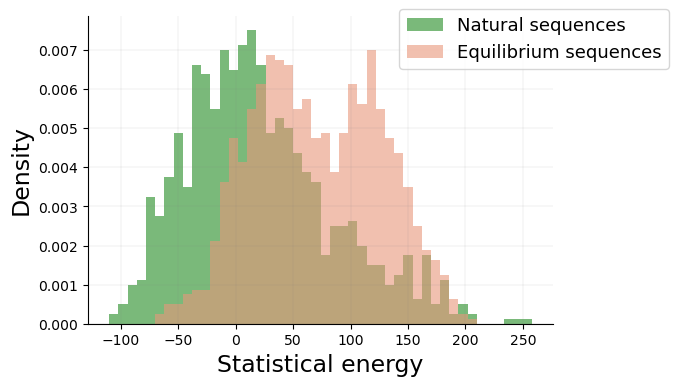

In [19]:
bins = collect(-110:8:260)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
matplotlib.pyplot.grid(color="grey", linestyle="-", linewidth=0.3, alpha = 0.3)


plt.hist(en_nat_trim, bins = bins, alpha = 0.6, 
label = "Natural sequences", density=true, color = "forestgreen")
plt.hist(en, bins = bins, alpha = 0.6, density= true, 
label = "Equilibrium sequences", color = "darksalmon")
plt.xlabel("Statistical energy", fontsize = 17)
plt.ylabel("Density", fontsize = 17)
plt.legend(bbox_to_anchor=(0.65, 1.05), loc="upper left", fontsize = 13)
plt.savefig("../img/paper_PNAS/energies", bbox_inches = "tight", dpi = 200)

## Gap profile

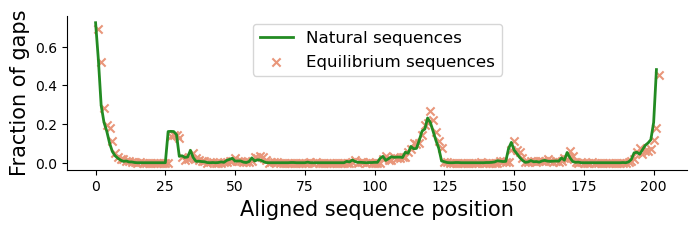

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (8, 2))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)


gaps_freq_nat = [sum(trimmed_nat[:,i] .== 21) for i in 1:N] ./ length(trimmed_nat[:,1])
gaps_freq = [sum(step_matrices[end][:,i] .== 21) for i in 1:N] ./ length(step_matrices[end][:,1])
r_gap =round.(corspearman(gaps_freq, gaps_freq_nat), digits = 2)
plt.plot(gaps_freq_nat, label ="Natural sequences", color = "forestgreen", linewidth = 2)
plt.scatter( collect(1:length(gaps_freq)), gaps_freq, label = "Equilibrium sequences", color = "darksalmon", marker = "x", s = 35)


plt.legend(fontsize = 12)
plt.xlabel("Aligned sequence position", fontsize = 15)
plt.ylabel("Fraction of gaps", fontsize = 15)
plt.savefig("../img/paper_PNAS/gap_frequency", bbox_inches = "tight", dpi = 200)
;
